In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json

In [33]:
carbon_levels = np.linspace(0, 0.06, 11)
max_carbon = np.max(carbon_levels)
carbon_levels = carbon_levels

In [34]:
first_step_folder = "../01_GeneratePureSpectrums/"
sims_filename = first_step_folder+"sims_01.csv"
sims_df = pd.read_csv(sims_filename)
pure_spec_sims_df = sims_df

pickle_files = first_step_folder+'specs/'+sims_df['filename']+'.pkl'
soil_resolutions = sims_df['soil_resolution']
res_info_files = first_step_folder+'ResInfo/res_info_'+soil_resolutions+'.json'
res_infos = [json.load(open(res_info_file, 'r')) for res_info_file in res_info_files]
pure_res_infos = res_infos

tally_t = 1
tally_data = [pickle.load(open(pickle_file, 'rb')) for pickle_file in pickle_files]
tally_binss = [td[0] for td in tally_data]
tally_spetra = [td[1] for td in tally_data]
detector_bins = [bins[tally_t][-2] for bins in tally_binss]
detector_spectra = [spec[tally_t] for spec in tally_spetra]
pure_detector_spectra = detector_spectra

In [35]:
print(pure_spec_sims_df.iloc[21])
print(pure_spec_sims_df.iloc[22])


soil_resolution                    7x7x7
function                        Feldspar
id                                  1021
filename           7x7x7_Feldspar_001021
Name: 21, dtype: object
soil_resolution                   7x7x7
function                        Coconut
id                                 1022
filename           7x7x7_Coconut_001022
Name: 22, dtype: object


In [36]:
feldspar = pure_detector_spectra[21].squeeze()
coconut = pure_detector_spectra[22].squeeze()

In [37]:
def lin_conv(specs, coeffs):
    """
    Linear convolution of spectra with coefficients.
    """
    specs_arr = np.stack(specs, axis=0)
    coeffs_arr = np.array(coeffs).reshape((-1,) + (1,) * (specs_arr.ndim - 1))
    return np.sum(specs_arr * coeffs_arr, axis=0)

In [38]:
lin_conv_spectrums = [
    lin_conv(
        [feldspar, coconut], 
        [(1-carbon_levels[l]), 
            carbon_levels[l]]
            ) for l in range(len(carbon_levels))
]

lin_conv_spectrums = np.array(lin_conv_spectrums)

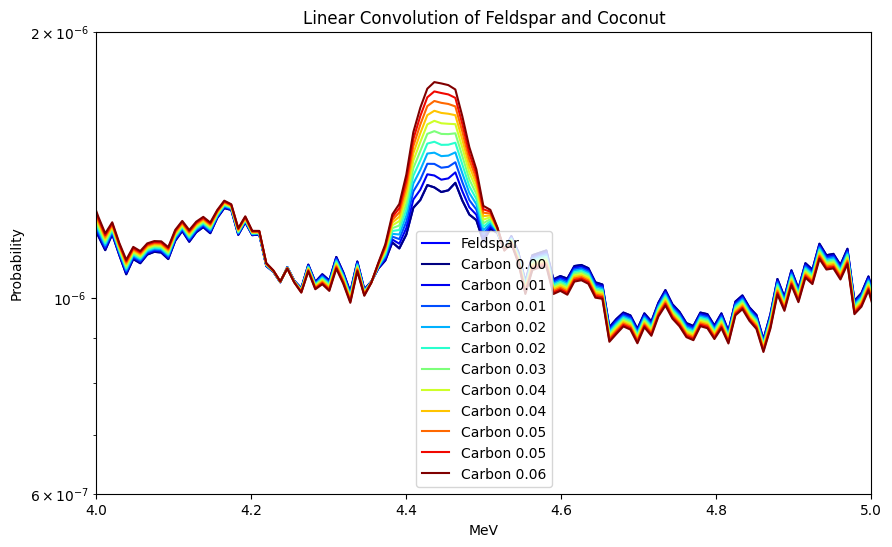

In [39]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(detector_bins[0], feldspar, label='Feldspar', color='blue')
for l in range(len(carbon_levels)):
    ax.plot(
        detector_bins[0], 
        lin_conv_spectrums[l], 
        label=f'Carbon {carbon_levels[l]:.2f}', 
        color=plt.cm.jet(carbon_levels[l] / max_carbon)
        )
ax.set_xlabel('MeV')
ax.set_ylabel('Probability')
ax.set_title('Linear Convolution of Feldspar and Coconut')
ax.legend()
plt.yscale('log')
plt.ylim(6e-7, 2e-6)
plt.xlim(4, 5)
plt.show()

In [41]:
sims_filename = "sims_03.csv"
sims_df = pd.read_csv(sims_filename)
levs_sims_df = sims_df.copy()


In [42]:
pickle_files = 'specs/'+sims_df['filename']+'.pkl'
soil_resolutions = sims_df['soil_resolution']
res_info_files = 'ResInfo/res_info_'+soil_resolutions+'.json'
res_infos = [json.load(open(res_info_file, 'r')) for res_info_file in res_info_files]
levs_res_infos = res_infos

In [43]:
tally_t = 1
tally_data = [pickle.load(open(pickle_file, 'rb')) for pickle_file in pickle_files]
tally_binss = [td[0] for td in tally_data]
tally_spetra = [td[1] for td in tally_data]
detector_bins = [bins[tally_t][-2] for bins in tally_binss]
detector_spectra = [spec[tally_t] for spec in tally_spetra]
detector_spectra = np.array(detector_spectra)
detector_spectra = detector_spectra.squeeze()
levs_detector_spectra = detector_spectra

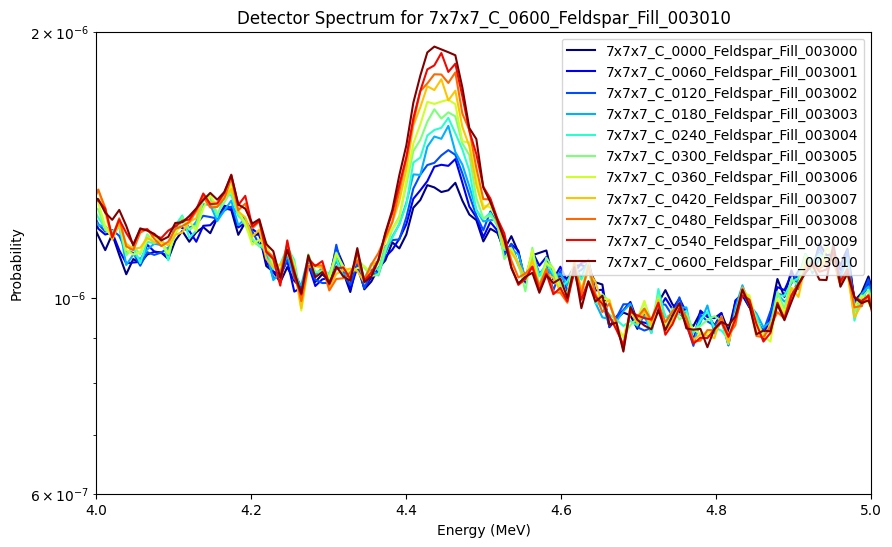

In [44]:
plt.figure(figsize=(10, 6))
for i, detector_spectrum in enumerate(detector_spectra):
    detector_energy_bins = detector_bins[i]
    plt.plot(
        detector_energy_bins, 
        levs_detector_spectra[i], 
        label=sims_df['filename'][i],
        color=plt.cm.jet(carbon_levels[i]/max_carbon)
        )
plt.xlabel('Energy (MeV)')
plt.ylabel('Probability')
plt.title('Detector Spectrum for ' + sims_df['filename'][i])
plt.legend()
plt.yscale('log')
plt.ylim(6e-7, 2e-6)
plt.xlim(4, 5)
plt.show()

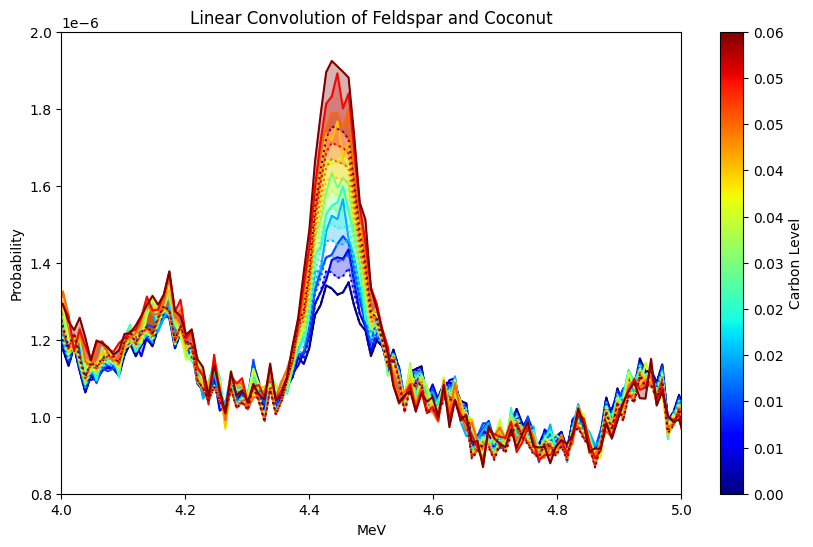

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for l in range(len(carbon_levels)):
    ax.plot(
        detector_bins[0], 
        lin_conv_spectrums[l], 
        label=f'LinConv-{carbon_levels[l]:.4f}', 
        color=plt.cm.jet(carbon_levels[l] / max_carbon),
        linestyle='dotted'
        )
    
    ax.plot(
        detector_bins[0], 
        levs_detector_spectra[l], 
        label=f'True-{carbon_levels[l]:.4f}',
        color=plt.cm.jet(carbon_levels[l]/max_carbon)
        )
    fill_between_x = detector_bins[0]
    fill_between_y = np.interp(fill_between_x, detector_bins[0], lin_conv_spectrums[l])
    ax.fill_between(
        fill_between_x, 
        fill_between_y, 
        levs_detector_spectra[l], 
        color=plt.cm.jet(carbon_levels[l] / max_carbon), 
        alpha=0.3
    )
ax.set_xlabel('MeV')
ax.set_ylabel('Probability')
ax.set_title('Linear Convolution of Feldspar and Coconut')
# ax.legend()
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap='jet'), 
    ax=ax, 
    label='Carbon Level',
    ticks=np.linspace(0, 1, 11),
)
cbar.set_ticklabels([f'{cl:.2f}' for cl in np.linspace(0, max_carbon, 11)])
# plt.yscale('log')
plt.ylim(8e-7, 2e-6)
plt.xlim(4, 5)
plt.show()

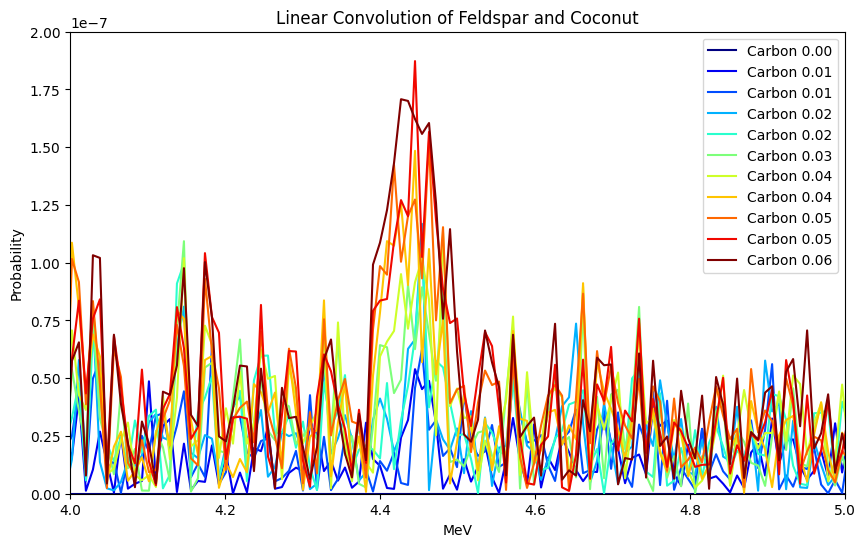

In [55]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# ax.plot(detector_bins[0], feldspar, label='Feldspar', color='blue')
for l in range(len(carbon_levels)):
    ax.plot(
        detector_bins[0], 
        np.abs(levs_detector_spectra-lin_conv_spectrums)[l], 
        label=f'Carbon {carbon_levels[l]:.2f}', 
        color=plt.cm.jet(carbon_levels[l] / max_carbon)
        )
ax.set_xlabel('MeV')
ax.set_ylabel('Probability')
ax.set_title('Linear Convolution of Feldspar and Coconut')
ax.legend()
# plt.yscale('log')
plt.ylim(0, 2e-7)
plt.xlim(4, 5)
plt.show()